In [1]:
import random
import re
import numpy as np
import pandas as pd
import multiprocessing as mp
import nltk
from nltk import wordnet, pos_tag, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

Датасет с каггла, ячейки не выполены, так как работал в каггле.

In [ ]:
df = pd.read_csv('../input/mercaridataset/train.tsv', sep='\t')
delete = ['train_id', 'item_condition_id', 'category_name', 'brand_name', 'price', 'shipping']
df = df.drop(columns=delete)
print(df.shape) # = (1482535, 2)
df = df.dropna()
print(df.shape) # = (1482531, 2)

In [ ]:
def build_document(id):
    return Document(df['name'][id], df['item_description'][id])

In [ ]:
class Document:
    def __init__(self, title, text):
        # можете здесь какие-нибудь свои поля подобавлять
        self.title = title
        self.text = text

    def format(self, query):
        # возвращает пару тайтл-текст, отформатированную под запрос
        return [self.title, self.text[:100] + ' ...']

In [ ]:
df = df.reset_index(drop=True)

In [ ]:
pool = mp.Pool(4)

In [ ]:
%%time
index = list(map(build_document, [i for i in range(df.shape[0])]))
print(1)

In [ ]:
%%time
index = pool.map(build_document, [i for i in range(df.shape[0])])
print(1)

параллельное ~в 2 раза быстрее

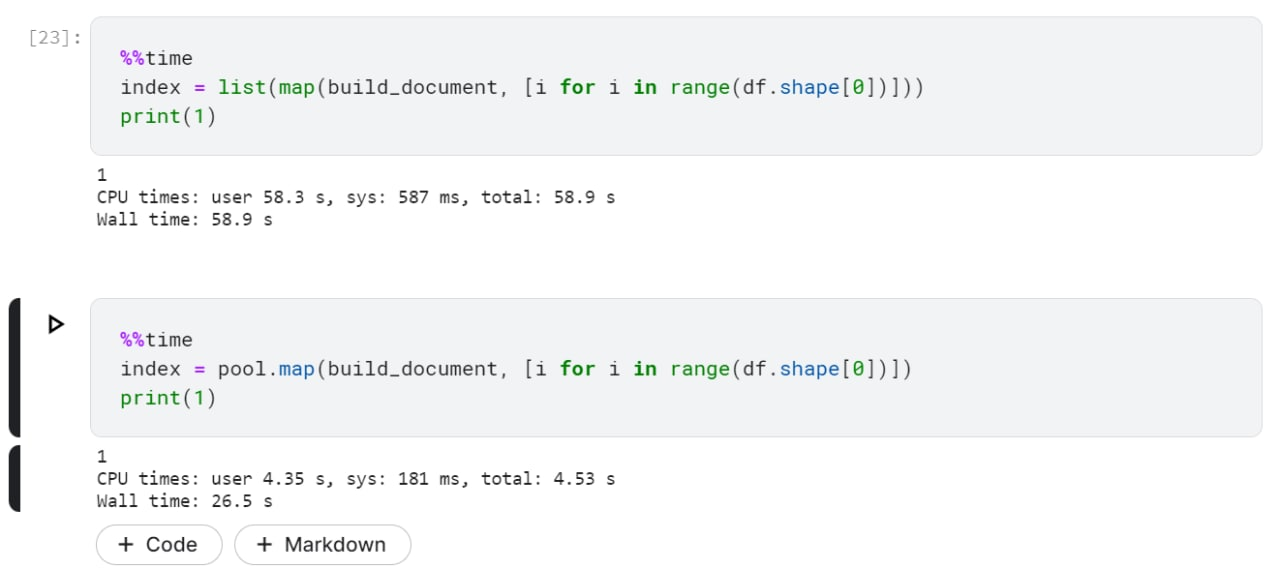

In [ ]:
import re
import numpy as np
import pandas as pd
import multiprocessing as mp
import nltk
from nltk import wordnet, pos_tag, WordNetLemmatizer

всё вместе

In [ ]:
out = {}

In [ ]:
def build_document(id):
    return Document(df['name'][id], df['item_description'][id])

def get_wordnet_pos(treebank_tag):
    my_switch = {
        'J': wordnet.wordnet.ADJ,
        'V': wordnet.wordnet.VERB,
        'N': wordnet.wordnet.NOUN,
        'R': wordnet.wordnet.ADV,
    }
    for key, item in my_switch.items():
        if treebank_tag.startswith(key):
            return item
    return wordnet.wordnet.NOUN

def my_lemmatizer(sent):
    lemmatizer = WordNetLemmatizer()
    tokenized_sent = sent.split()
    pos_tagged = [(word, get_wordnet_pos(tag))
                 for word, tag in pos_tag(tokenized_sent)]
    return ' '.join([lemmatizer.lemmatize(word, tag)
                    for word, tag in pos_tagged])

def document_dictionary(id):
    s = index[id].title + " " + index[id].text
    s = re.sub('[^a-z0-9\s]', '', s.lower())
    s = my_lemmatizer(s)
    out[id] = s
    for word in set(s):
        if word in reverse_index:
            reverse_index[word].append(id)
        else:
            reverse_index[word] = [id]

df = pd.read_csv('../input/mercaridataset/train.tsv', sep='\t')
delete = ['train_id', 'item_condition_id', 'category_name', 'brand_name', 'price', 'shipping']
df = df.drop(columns=delete)
print(df.shape) # = (1482535, 2)
df = df.dropna()
print(df.shape) # = (1482531, 2)
df = df.reset_index(drop=True)
reverse_index = {}
pool = mp.Pool(4)
index = pool.map(build_document, [i for i in range(df.shape[0])])
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

In [ ]:
def get_reverse_index(id):
    document_dictionary(id)


In [ ]:
%%time
index = pool.map(get_reverse_index, [i for i in range(10000)])
print(1)

Только 10000 данных, разница в 2.6 раз => все данные 1482531 / 10000 * 10 / 60 = ~25 минут вместо где-то 1 часа

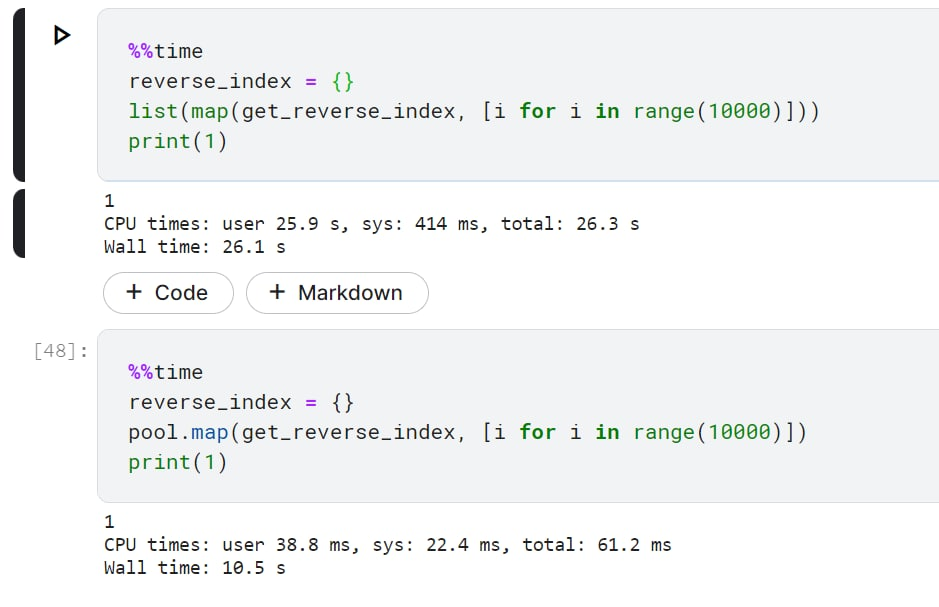

In [ ]:
%%time
index = pool.map(get_reverse_index, [i for i in range(df.shape[0])])
print(1)

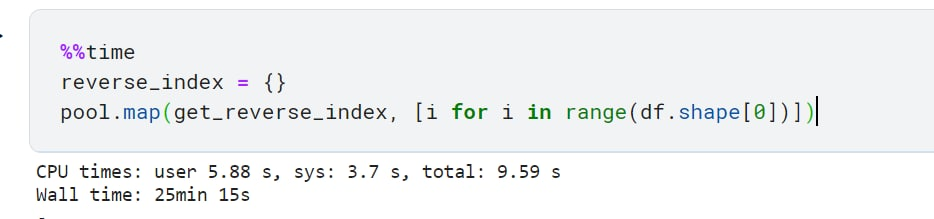

Предподсчёт айди текста -> слова; слова -> айди текстов:

In [ ]:
with open(r"lemmatizer.txt", "w") as file:
    for id in range(df.shape[0]):
        file.write(out[id] + '\n')

In [ ]:
import zipfile
       
jungle_zip = zipfile.ZipFile('lemmatizer.zip', 'w')
jungle_zip.write('lemmatizer.txt', compress_type=zipfile.ZIP_DEFLATED)
jungle_zip.close()

In [ ]:
from IPython.display import FileLink
FileLink('lemmatizer.zip')

In [ ]:
with open(r"dict.txt", "w") as file:
    for word in reverse_index:
        s = word + ": "
        for id in reverse_index[word]:
            s += str(id) + " "
        file.write(s + '\n')

In [ ]:
import zipfile
       
jungle_zip = zipfile.ZipFile('dict.zip', 'w')
jungle_zip.write('dict.txt', compress_type=zipfile.ZIP_DEFLATED)
jungle_zip.close()

In [ ]:
from IPython.display import FileLink
FileLink('dict.zip')